In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
%matplotlib inline
from geopandas import GeoSeries
import os
import h5py
from shapely.geometry import Point,Polygon
import glob
from rasterio import features
from topolib import gda_lib

In [4]:
ATL06_list = glob.glob('/Users/hpm/HP_DRIVE/ICESat2-hackweek/topohack/data2/**/*.h5')

In [5]:
ATL06_list

['/Users/hpm/HP_DRIVE/ICESat2-hackweek/topohack/data2/161138682/processed_ATL06_20181110092841_06530106_001_01.h5',
 '/Users/hpm/HP_DRIVE/ICESat2-hackweek/topohack/data2/161210043/processed_ATL06_20181214194017_11790102_001_01.h5',
 '/Users/hpm/HP_DRIVE/ICESat2-hackweek/topohack/data2/161313271/processed_ATL06_20190209050825_06530206_001_01.h5',
 '/Users/hpm/HP_DRIVE/ICESat2-hackweek/topohack/data2/161252239/processed_ATL06_20190112181620_02340202_001_01.h5']

In [6]:
ATL06_fn = ATL06_list[0]

In [7]:
ATL06_fn

'/Users/hpm/HP_DRIVE/ICESat2-hackweek/topohack/data2/161138682/processed_ATL06_20181110092841_06530106_001_01.h5'

# read a Raster Data

In [4]:

dem_fn = '/home/jovyan/data/USCOGM20160604f1a1_bareDEM_3p0m.tif'
ds = rasterio.open(dem_fn)

# read a ATL06 hdf5 into a geodataframe

In [11]:
dataset_dict={'land_ice_segments':['h_li', 'delta_time','longitude','latitude'], 'land_ice_segments/ground_track':['x_atc']}

In [12]:
ATL06_gdf = gda_lib.ATL06_2_gdf(ATL06_fn,dataset_dict)
ATL06_gdf = ATL06_gdf.to_crs(ds.crs)

In [5]:
dem = ds.read(1)
dem = np.ma.masked_equal(dem,gda_lib.get_ndv(ds))

In [6]:
xmin,ymin,xmax,ymax = ds.bounds

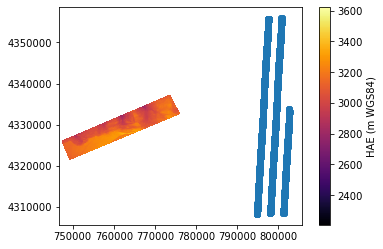

In [24]:
fig,ax = plt.subplots()
im = ax.imshow(dem,cmap='inferno',extent=[xmin,xmax,ymin,ymax])
plt.colorbar(im,label='HAE (m WGS84)')
ATL06_gdf.plot(ax=ax)

In [16]:
ATL06_gdf_list = [gda_lib.ATL06_2_gdf(x,dataset_dict) for x in ATL06_list]
ATL06_gdf_list = [x.to_crs(ds.crs) for x in ATL06_gdf_list]

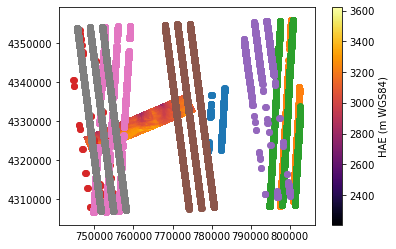

In [25]:
fig,ax = plt.subplots()
im = ax.imshow(dem,cmap='inferno',extent=[xmin,xmax,ymin,ymax])
plt.colorbar(im,label='HAE (m WGS84)')
for gdf in ATL06_gdf_list:
    gdf.plot(ax=ax)
#ATL06_gdf.plot(ax=ax)

In [53]:
x_atc,z = sample_values(ds,ATL06_gdf_list[6])

In [63]:
x_atc = np.ma.array(x_atc,mask = z.mask)

In [67]:
fig,ax = plt.subplots()
ax.scatter(x_atc,z)
ax.scatter(ATL06_gdf_list[6].x_atc.values,ATL06_gdf_list[6].h_li.values,marker='^',c='red',s=1)
#im = ax.imshow(dem,cmap='inferno',extent=[xmin,xmax,ymin,ymax])
#plt.colorbar(im,label='HAE (m WGS84)')
#for gdf in ATL06_gdf_list:
 #   gdf.plot(ax=ax)
#ATL06_gdf.plot(ax=ax)

FigureCanvasNbAgg()

In [19]:
df1,df2,df3,df4,df5,df6 = [x for x_,x in ATL06_gdf_list[6].groupby(ATL06_gdf_list[6]['p_b'])] #pick 1 ATL06 and seperate it into 6 beams

In [20]:
df_list = [df1,df2,df3,df4,df5,df6]

Text(0.5, 0.98, 'Nearest neighbour sampling')

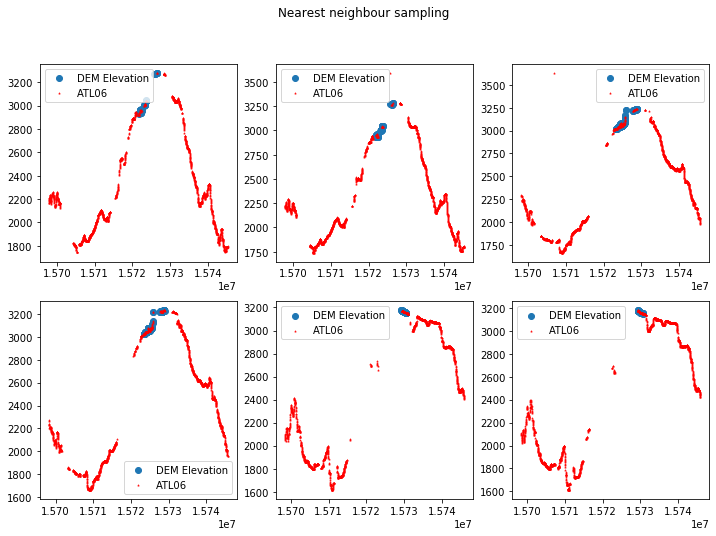

In [26]:
fig,axs = plt.subplots(2,3,figsize=(12,8))
for i,ax in enumerate(fig.axes):
    x_atc,z_hp = gda_lib.sample_near_nbor(ds,df_list[i])
    ax.scatter(x_atc,z_hp,label='DEM Elevation')
    ax.scatter(df_list[i].x_atc.values,df_list[i].h_li.values,marker='^',c='red',s=1,label='ATL06') #this is nearest neighbour sampling
    ax.legend()   
plt.suptitle('Nearest neighbour sampling')
#ax.scatter(gdf_6_p1b1.x_atc.values,gdf_6_p1b1.h_li.values,marker='^',c='red',s=1)

Text(0.5, 0.98, 'Buffer sampling with window radius of 20 m')

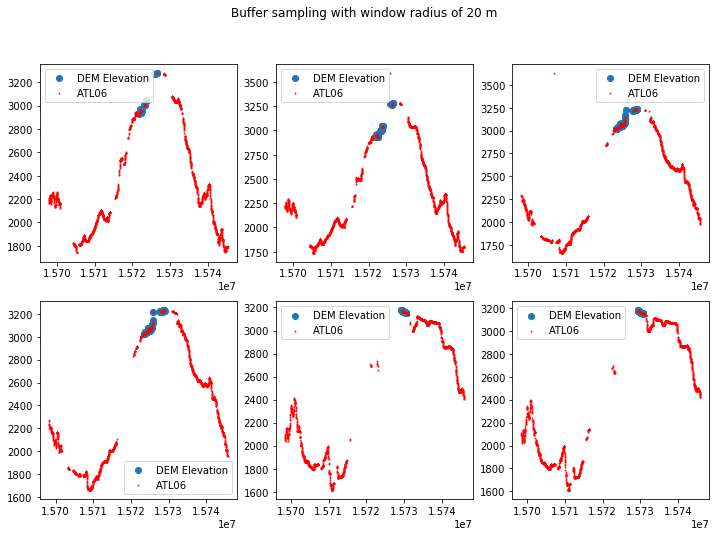

In [27]:
fig,axs = plt.subplots(2,3,figsize=(12,8))
for i,ax in enumerate(fig.axes):
    x_atc,z_hp = gda_lib.buffer_sampler(ds,df_list[i],20) #this is buffer sampling
    ax.scatter(x_atc,z_hp,label='DEM Elevation')
    ax.scatter(df_list[i].x_atc.values,df_list[i].h_li.values,marker='^',c='red',s=1,label='ATL06') 
    ax.legend()   
plt.suptitle('Buffer sampling with window radius of 20 m')
#ax.scatter(gdf_6_p1b1.x_atc.values,gdf_6_p1b1.h_li.values,marker='^',c='red',s=1)

In [28]:
#not important from here on

In [47]:
def mask_by_shp(geom,array,ds,reverse=False): 
    if (type(ds) == rasterio.io.DatasetReader):
        transform = ds.transform
    else:
        transform = affine.Affine.from_gdal(*ds.GetGeoTransform())
    shp = features.rasterize(geom,out_shape=np.shape(array),fill=-9999,transform=transform,dtype=float)
    shp_mask = np.ma.masked_where(shp==-9999,shp)
    if reverse:
        req_mask = ~shp_mask.mask
    else:
        req_mask = shp_mask.mask
    masked_array = np.ma.array(array,mask=req_mask)
    return masked_array

In [53]:
def median_profile(ds,geom,buff,val='med'):
    """
    sample values from raster at the given ICESat-2 points
    using a buffer distance, and return median/mean
    """
    # reproject the shapefile to raster projection
    x_min,y_min,x_max,y_max = ds.bounds
    geom = geom.to_crs(ds.crs)
    #filter geom outside bounds 
    geom = geom.cx[x_min:x_max,y_min:y_max]
    #adjust for no data
    no_data = get_ndv(ds)
    array = ds.read(1)
    array = np.ma.masked_equal(array,no_data)
    geom['geometry'] = geom.geometry.buffer(buff)
   # print(type(geom))
    out_list = []
    for i,row in geom.iterrows():
       # print(type(row))
        poly_array =  mask_by_shp(GeoSeries(row.geometry),array,ds)
        if val == 'med':
            out = np.ma.median(poly_array)
        else:
            out = np.ma.mean(poly_array)
        out_list.append(out)
    return geom.x_atc.values, out_list

In [112]:
array = ds.read(1,masked=True)

In [54]:
median_profile(ds,df_list[2],20)

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


KeyboardInterrupt: 

In [115]:
ds.nodata ==None

True

In [116]:
ds.profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 9955, 'height': 5857, 'count': 1, 'crs': CRS.from_epsg(32612), 'transform': Affine(3.0, 0.0, 746619.0,
       0.0, -3.0, 4338012.0), 'tiled': False, 'interleave': 'band'}

In [4]:
import gdal


In [5]:
band = gdal.Open(dem_fn,2).GetRasterBand(1)

In [6]:
band

<osgeo.gdal.Band; proxy of <Swig Object of type 'GDALRasterBandShadow *' at 0x7fba046ed4e0> >

In [ ]:
band.GetNoDataValue()

In [1]:
band.GetNoDataValue()

NameError: name 'band' is not defined

In [10]:
def get_ndv(ds):
    no_data = ds.nodatavals[0]
    if no_data == None:
        #this means no data is not set in tif tag, nead to cheat it from raster
        ndv = ds.read(1)[0,0]
    else:
        ndv = no_data
    return ndv

In [67]:
dem

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20,
  dtype=float32)

In [57]:
df_buffered = df_list[5].copy()
df_buffered['geometry'] = df_buffered.geometry.buffer(20)

In [68]:
dem_filled = np.ma.filled(dem,np.nan)

In [73]:
dem_filled

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [69]:
import rasterstats as rs

In [91]:
profile_stats = gpd.GeoDataFrame.from_features(rs.zonal_stats(df_buffered,dem,affine=ds.transform,geojson_out=True,stats="median",nodata=-9999))

In [92]:
profile_stats = profile_stats.rename(columns={'median':'med'})

In [94]:
profile_stats.head()

beam    delta_time                                           filename  \
0   1.0  2.992328e+07  /home/jovyan/data/gm_noCoverage_ICESat2/proces...   
1   1.0  2.992328e+07  /home/jovyan/data/gm_noCoverage_ICESat2/proces...   
2   1.0  2.992328e+07  /home/jovyan/data/gm_noCoverage_ICESat2/proces...   
3   1.0  2.992328e+07  /home/jovyan/data/gm_noCoverage_ICESat2/proces...   
4   1.0  2.992328e+07  /home/jovyan/data/gm_noCoverage_ICESat2/proces...   

                                            geometry         h_li   latitude  \
0  POLYGON ((752773.3263820586 4354161.339010223,...  2109.107178  39.299962   
1  POLYGON ((752771.9874215935 4354141.33305324, ...  2103.466797  39.299782   
2  POLYGON ((752770.6514802576 4354121.325010256,...  2094.860352  39.299603   
3  POLYGON ((752769.3620773242 4354101.314930591,...  2086.094971  39.299423   
4  POLYGON ((752768.0751188451 4354081.304702571,...  2074.346680  39.299243   

    longitude  med      p_b  pair         x_atc  
0 -108.068931  NaN  3.0_1.0   3.0  1.569845e+07  
1 -108.068954  NaN  3.0_1.0   3.0  1.569847e+07  
2 -108.068977  NaN  3.0_1.0   3.0  1.569849e+07  
3 -108.068999  NaN  3.0_1.0   3.0  1.569851e+07  
4 -108.069021  NaN  3.0_1.0   3.0  1.569853e+07

In [90]:
fig,ax = plt.subplots()
ax.scatter(profile_stats.x_atc.values,profile_stats.med.values)

FigureCanvasNbAgg()

In [114]:
def buffer_sampler(ds,geom,buffer,val='median',ret_gdf=False):
    """
    sample values from raster at the given ICESat-2 points
    using a buffer distance, and return median/mean or a full gdf ( if return gdf=True)
    Inputs = rasterio dataset, Geodataframe containing points, buffer distance, output value = median/mean (default median)
    and output format list of x_atc,output_value arrays (default) or  full gdf
    """
    ndv = get_ndv(ds)
    array = ds.read(1)
    gt = ds.transform
    stat = val
    geom = geom.to_crs(ds.crs)
    geom['geometry'] = geom.geometry.buffer(buffer)
    json_stats = rs.zonal_stats(geom,array,affine=gt,geojson_out=True,stats=stat,nodata=ndv)
    gdf = gpd.GeoDataFrame.from_features(json_stats)
    if val =='median':
        gdf = gdf.rename(columns={'median':'med'})
        call = 'med'
    else:
        gdf = gdf.rename(columns={'mean':'avg'})
        call = 'avg'
    if ret_gdf:
        out_file = gdf
    else:
        out_file = [gdf.x_atc.values,gdf[call].values]
    return out_file

In [1]:
from topolib import gda_lib

In [29]:
x,y = gda_lib.buffer_sampler(ds,df_list[5],20,'mean')

In [32]:
!pwd

/home/jovyan/topohack/ShashankBice
